In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import findspark
findspark.init()

In [3]:
%load_ext autoreload
%autoreload 2
from utils.utilities import read_file,write_output
from utils.business_kpi import get_top_n_job_posting
from utils.business_kpi import get_avg_salary_per_degree
from utils.business_kpi import get_avg_salary_agency
from utils.business_kpi import get_top_job_posting_salary_agency
from utils.business_kpi import get_avg_salary_per_category_per_frequency
from utils.business_kpi import get_highest_paid_skill

In [102]:
from pyspark.sql import SparkSession

spark = SparkSession.builder. \
    appName("KPI-s"). \
    getOrCreate()
spark.conf.set("spark.debug.maxToStringFields", 100000)
spark.conf.set("spark.sql.debug.maxToStringFields", 100000)

## Variables

In [103]:
input_path="/dataset/output/cleaned/"
output_path='file:///dataset/output/'

### Read data

In [108]:
df=read_file(input_path)

## List of KPIs to be resolved:
#### 1. What's the number of jobs posting per category (Top 10)?
#### 2. What's the salary distribution per job category?
#### 3. Is there any correlation between the higher degree and the salary?
#### 4. What's the job posting having the highest salary per agency?
#### 5. What's the job postings average salary per agency for the last 2 years?
#### 6. What are the highest paid skills in the US market?

## 1. What's the number of jobs posting per category (Top 10)?

In [109]:
top_n_result = get_top_n_job_posting(df,10).drop("row_number")
top_n_result.show(10,False)

22/08/28 15:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 15:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 15:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 15:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 15:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 15:50:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 1

In [36]:
jc_jobs=top_n_result.select('job_category','number_of_jobs').toPandas()
jc_positions=top_n_result.select('job_category','no_of_positions').toPandas()

22/08/28 03:30:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 03:30:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 03:30:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 03:30:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 03:30:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 03:30:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/08/28 0

#### Write Output

In [ ]:
# write_output(top_n_result,output_path+'top_n_job_posting/')

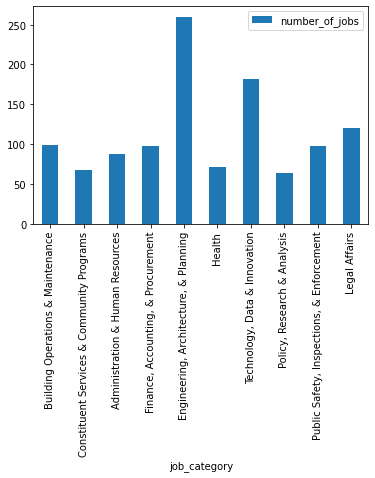

In [40]:
#visualise top 10 job postings
from matplotlib import pyplot as plt
jc_jobs.plot.bar(x='job_category')
plt.show()

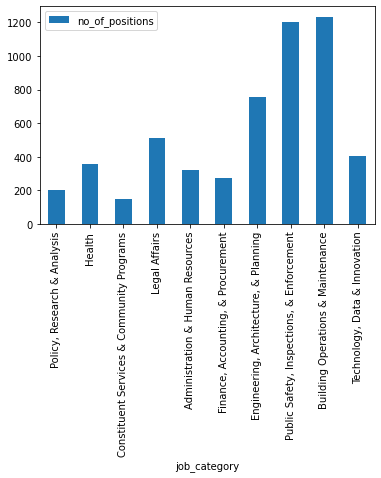

In [41]:
jc_positions.plot.bar(x='job_category')
plt.show()

## 2. What's the salary distribution per job category?

In [105]:
avg_sal_result = get_avg_salary_per_category_per_frequency(df)
avg_sal_result.show(5)

+--------------------+----------------+-----------------+
|        job_category|salary_frequency|       avg_salary|
+--------------------+----------------+-----------------+
|Policy, Research ...|          Annual|71020.12162162163|
|Administration & ...|          Annual|          53075.5|
|Administration & ...|          Annual|         110000.0|
|                null|          Annual|          82661.0|
|Health Technology...|          Annual|86833.33333333333|
+--------------------+----------------+-----------------+
only showing top 5 rows



In [120]:
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

windowSpec  = Window.partitionBy("salary_frequency").orderBy(f.col('avg_salary').desc())
result = avg_sal_result.withColumn("row_number",f.row_number().\
                       over(Window.partitionBy("salary_frequency").\
                            orderBy(f.col('avg_salary').desc()))).filter("row_number < 4")
result_DF = result.toPandas().set_index("job_category").pivot(columns="salary_frequency",values="avg_salary")

In [126]:
result.show(10)

+--------------------+----------------+------------------+----------+
|        job_category|salary_frequency|        avg_salary|row_number|
+--------------------+----------------+------------------+----------+
|Administration & ...|          Annual|          218587.0|         1|
|Engineering, Arch...|          Annual|          198518.0|         2|
|Engineering, Arch...|          Annual|          196042.5|         3|
|Engineering, Arch...|           Daily|            539.12|         1|
|Engineering, Arch...|           Daily|            486.72|         2|
|Engineering, Arch...|           Daily|            363.92|         3|
|Constituent Servi...|          Hourly|58.741499999999995|         1|
|Building Operatio...|          Hourly|             48.95|         2|
|Engineering, Arch...|          Hourly| 48.32333333333333|         3|
+--------------------+----------------+------------------+----------+



<AxesSubplot:xlabel='job_category'>

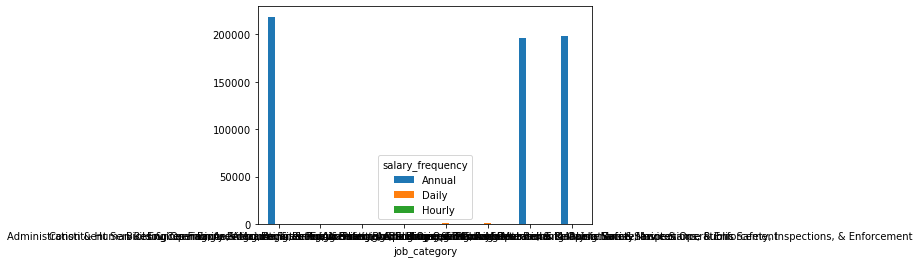

In [121]:
result_DF.plot.bar(rot=0)

#### Write Output File

In [ ]:
# write_output(avg_sal_result,output_path+'avg_salary_per_category_per_frequency/')

## 3. Is there any correlation between the higher degree and the salary?

In [19]:
sal_per_degree_result = get_avg_salary_per_degree(df)
sal_per_degree_result.show(20,False)

+-------------+------------------+----------+------------------+
|degree       |Min_Salary        |Max_Salary|Avg_Salary        |
+-------------+------------------+----------+------------------+
|graduate     |61345.0           |121950.0  |83318.6875        |
|college      |59572.0           |97115.5   |77920.58333333333 |
|technology   |51435.5           |51435.5   |51435.5           |
|doctorate    |62693.0           |116000.0  |84516.27011494253 |
|associate    |29.06075          |137500.0  |59248.71057627388 |
|masters      |51483.0           |120474.5  |87392.06910394266 |
|science      |34.519999999999996|86194.0   |49466.48960000001 |
|baccalaureate|21.55175          |209585.0  |75699.9520885258  |
|ba/bs        |49956.5           |49956.5   |49956.5           |
|Others       |9.555             |217201.0  |57234.167652677446|
|bs/ba        |121950.0          |167500.0  |144725.0          |
|architecture |61567.0           |76000.0   |68950.16666666667 |
|professional |51535.0   

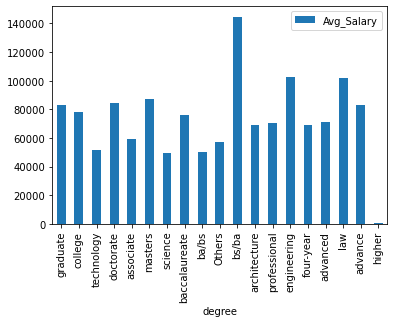

In [26]:
#visualise degree and salary
from matplotlib import pyplot as plt
pdf=sal_per_degree_result.toPandas()
pdf.plot.bar(x='degree',y='Avg_Salary')
plt.show()

#### Write Output File

In [ ]:
# write_output(sal_per_degree_result,output_path+'avg_salary_per_degree/')

## 4. What's the job posting having the highest salary per agency?

In [22]:
df.columns

['job_id',
 'agency',
 'posting_type',
 'no_of_positions',
 'business_title',
 'civil_service_title',
 'title_code_no',
 'level',
 'job_category',
 'full-time/part-time_indicator',
 'salary_range_from',
 'salary_range_to',
 'salary_frequency',
 'work_location',
 'division/work_unit',
 'job_description',
 'minimum_qual_requirements',
 'preferred_skills',
 'additional_information',
 'to_apply',
 'hours/shift',
 'work_location_1',
 'recruitment_contact',
 'residency_requirement',
 'posting_date',
 'post_until',
 'posting_updated',
 'process_date']

In [15]:
top_job_result = get_top_job_posting_salary_agency(df)
top_job_result.show()

+--------------------+------+--------------------+-----------------+---------------+----------+
|              agency|job_id|      business_title|salary_range_from|salary_range_to|avg_salary|
+--------------------+------+--------------------+-----------------+---------------+----------+
|ADMIN FOR CHILDRE...|407253|Assistant Commiss...|          78574.0|       156375.0|  117474.5|
|ADMIN TRIALS AND ...|417207|Assistant General...|          80000.0|       100000.0|   90000.0|
| BOARD OF CORRECTION|387034|IT Systems Suppor...|          89509.0|       102936.0|   96222.5|
|BOROUGH PRESIDENT...|386195|         Engineering|          65783.0|        95270.0|   80526.5|
|BUSINESS INTEGRIT...|403516|Executive Agency ...|          90000.0|       100000.0|   95000.0|
|CIVILIAN COMPLAIN...|421027|    Policy and Legal|          63031.0|       168433.0|  115732.0|
|CONFLICTS OF INTE...|412080|DIRECTOR OF ENFOR...|         100000.0|       170000.0|  135000.0|
|    CONSUMER AFFAIRS|425321|Assistant C

#### Write Output File

In [ ]:
# write_output(top_job_result,output_path+'top_job_posting_salary_agency/')

## 5. What's the job postings average salary per agency for the last 2 years?

In [18]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
avg_sal_result = get_avg_salary_agency(df,False)
avg_sal_result.show(10,False)

+-----------------------------+---------------------+-------------------+------------------+
|agency                       |avg_salary_range_from|avg_salary_range_to|avg_salary        |
+-----------------------------+---------------------+-------------------+------------------+
|FIRE DEPARTMENT              |63359.345554545456   |75692.69002727274  |69526.0177909091  |
|ADMIN FOR CHILDREN'S SVCS    |59931.603923529416   |85165.63494411766  |72548.61943382354 |
|TAX COMMISSION               |10955.166666666666   |46378.96666666667  |28667.066666666666|
|HRA/DEPT OF SOCIAL SERVICES  |59334.951535483866   |81065.29427741935  |70200.12290645161 |
|TAXI & LIMOUSINE COMMISSION  |54565.37987089552    |67516.67985671642  |61041.02986380596 |
|EQUAL EMPLOY PRACTICES COMM  |58664.0              |67463.5            |63063.75          |
|DEPARTMENT OF BUSINESS SERV. |46938.18948          |63847.399595999996 |55392.794537999995|
|DEPT OF DESIGN & CONSTRUCTION|60862.59154929577    |114836.0845070422

#### Write Output File

In [20]:
# write_output(avg_sal_result,output_path+'avg_salary_agency/')

## 6. What are the highest paid skills in the US market?

In [55]:
highest_paid_result=get_highest_paid_skill(df)

In [56]:
print(highest_paid_result)

The highest paid skills in the US market is: The Deputy Commissioner position requires excellent leadership communication and client service skills as well as a passion for driving innovation continuous improvement and efficiency and implementing workforce strategies to recruit develop and retain the most qualified and diverse talent in a customer service environment The selected candidate will be expected to work closely with Agency and oversight counterparts and must have excellent management skills focused on staff alignment with the Bureau s vision goals and career development In addition he/she must be an effective team player capable of sustaining a culture of excellence in the delivery of customer service to internal partners and possess the ability to establish and maintain effective external partnerships and collaboration Specifically the following skills and abilities are required to be successful in this role 7-10 years relevant work experience leading customer focused funct